# Heritability Analysis

##### [OpenMendel Programming Workshop](http://www.genetics.ucla.edu/courses/statgene/Mendel/)
##### Dr. Hua Zhou, [huazhou@ucla.edu](mailto: huazhou@ucla.edu)
##### Department of Biostatistics, UCLA
##### Mar 9, 2017

As an application of the variance component model, this note demonstrates the workflow for heritability analysis in genetics, using a sample data set `cg10k` with **6,670** individuals and **630,860** SNPs. Person IDs and phenotype names are masked for privacy. `cg10k.bed`, `cg10k.bim`, and `cg10k.fam` is a set of Plink files in binary format. `cg10k_traits.txt` contains 13 phenotypes of the 6,670 individuals.

In [1]:
;ls cg10k*.*

cg10k.bed
cg10k.bim
cg10k.fam
cg10k.jld
cg10k_traits.txt


Machine information:

In [2]:
versioninfo()

Julia Version 0.5.1
Commit 6445c82 (2017-03-05 13:25 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-6920HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


## Read in binary SNP data

We will use the [`SnpArrays.jl`](https://github.com/Hua-Zhou/SnpArrays.jl) package to read in binary SNP data and compute the empirical kinship matrix. Issue `Pkg.clone("git@github.com:OpenMendel/SnpArrays.jl.git")` within `Julia` to install the `SnpArrays` package.

In [3]:
#Pkg.clone("git@github.com:OpenMendel/SnpArrays.jl.git")
using SnpArrays

In [4]:
# read in genotype data from Plink binary file (~40 secs on my laptop)
@time cg10k = SnpArray("cg10k")

 35.414072 seconds (299.11 k allocations: 1015.674 MB, 0.27% gc time)


## Summary statistics of SNP data

In [5]:
people, snps = size(cg10k)

(6670,630860)

In [6]:
# summary statistics (~26 secs on my laptop)
@time maf, _, missings_by_snp, = summarize(cg10k);

 25

In [7]:
# 5 number summary and average MAF (minor allele frequencies)
quantile(maf, [0.0 .25 .5 .75 1.0]), mean(maf)

(
[0.00841726 0.124063 … 0.364253 0.5],

0.24536516625042462)


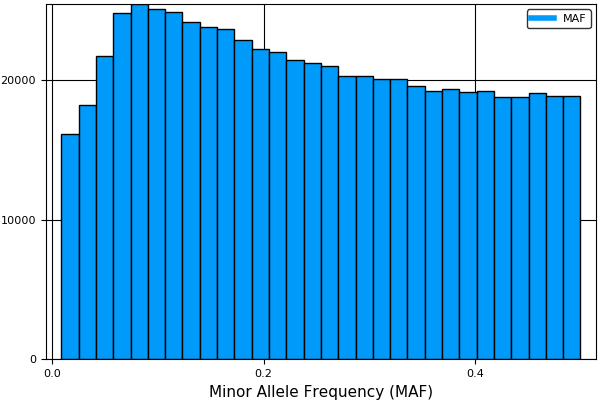

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [8]:
using Plots
pyplot()

histogram(maf, xlab = "Minor Allele Frequency (MAF)", label = "MAF")

In [9]:
# proportion of missing genotypes
sum(missings_by_snp) / length(cg10k)

0.0013128198764010824

In [10]:
# proportion of rare SNPs with maf < 0.05
countnz(maf .< 0.05) / length(maf)

0.07228069619249913

## Empirical kinship matrix

We estimate empirical kinship based on all SNPs by the genetic relation matrix (GRM). Missing genotypes are imputed on the fly by drawing according to the minor allele frequencies.

In [ ]:
# GRM using all SNPs (~10 mins on my laptop)
srand(123)
@time Φgrm = grm(cg10k; method = :GRM)

## Phenotypes

Read in the phenotype data and compute descriptive statistics.

In [ ]:
using DataFrames

cg10k_trait = readtable(
    "cg10k_traits.txt"; 
    separator = ' ',
    names = [:FID; :IID; :Trait1; :Trait2; :Trait3; :Trait4; :Trait5; :Trait6; 
             :Trait7; :Trait8; :Trait9; :Trait10; :Trait11; :Trait12; :Trait13],  
    eltypes = [String; String; Float64; Float64; Float64; Float64; Float64; 
               Float64; Float64; Float64; Float64; Float64; Float64; Float64; Float64]
    )

In [ ]:
describe(cg10k_trait)

In [ ]:
Y = convert(Matrix{Float64}, cg10k_trait[:, 3:15])
histogram(Y, layout = 13)

## Pre-processing data for heritability analysis

To prepare variance component model fitting, we form an instance of `VarianceComponentVariate`. The two variance components are $(2\Phi, I)$.

In [ ]:
using VarianceComponentModels

# form data as VarianceComponentVariate
cg10kdata = VarianceComponentVariate(Y, (2Φgrm, eye(size(Y, 1))))
fieldnames(cg10kdata)

In [ ]:
cg10kdata

Before fitting the variance component model, we pre-compute the eigen-decomposition of $2\Phi_{\text{GRM}}$, the rotated responses, and the constant part in log-likelihood, and store them as a `TwoVarCompVariateRotate` instance, which is re-used in various variane component estimation procedures.

In [ ]:
# pre-compute eigen-decomposition (~50 secs on my laptop)
@time cg10kdata_rotated = TwoVarCompVariateRotate(cg10kdata)
fieldnames(cg10kdata_rotated)

## Save intermediate results

We don't want to re-compute SnpArray and empirical kinship matrices again and again for heritibility analysis.

In [ ]:
#using JLD
#@save "cg10k.jld"

To load workspace

In [1]:
using SnpArrays, JLD, DataFrames, VarianceComponentModels, Plots
pyplot()
@load "cg10k.jld"
whos()

                          Base  40288 KB     Module
                       BinDeps    218 KB     Module
                         Blosc     59 KB     Module


                    ColorTypes   6642 KB     Module
                        Colors   6589 KB     Module
                        Compat   6312 KB     Module
                         Conda   6688 KB     Module
                          Core  15924 KB     Module
                    DataArrays   6603 KB     Module
                    DataFrames    646 KB     Module
                DataStructures    234 KB     Module
                        FileIO   7178 KB     Module
             FixedPointNumbers   6790 KB     Module
               FixedSizeArrays   6437 KB     Module
                          GZip   6217 KB     Module
                          HDF5   6875 KB     Module
                        Hiccup     84 KB     Module
                        IJulia   7414 KB     Module
                         Ipopt     32 KB     Module
              IterativeSolvers    333 KB     Module
                     Iterators     44 KB     Module
                           JLD   7052 KB     Module
            

## Heritability of single traits

We use Fisher scoring algorithm to fit variance component model for each single trait.

In [2]:
fieldnames(cg10kdata_rotated)

5-element Array{Symbol,1}:
 :Yrot    
 :Xrot    
 :eigval  
 :eigvec  
 :logdetV2

In [3]:
# heritability from single trait analysis
hST = zeros(13)
# standard errors of estimated heritability
hST_se = zeros(13)
# additive genetic effects
σ2a = zeros(13)
# enviromental effects
σ2e = zeros(13)

@time for trait in 1:13
    println(names(cg10k_trait)[trait + 2])
    # form data set for trait j
    traitj_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, trait], cg10kdata_rotated.Xrot, 
        cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
    # initialize model parameters
    traitj_model = VarianceComponentModel(traitj_data)
    # estimate variance components
    _, _, _, Σcov, _, _ = mle_fs!(traitj_model, traitj_data; solver=:Ipopt, verbose=false)
    σ2a[trait] = traitj_model.Σ[1][1]
    σ2e[trait] = traitj_model.Σ[2][1]
    @show σ2a[trait], σ2e[trait]
    #h, hse = heritability(traitj_model.Σ, Σcov)
    #heritability(traitj_model.Σ, Σcov)
    #hST[trait] = h[1]
    #hST_se[trait] = hse[1]
end

Trait1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

(σ2a[trait],σ2e[trait]) = (0.2601054897250638,0.7366255055516774)
Trait2
(σ2a[trait],σ2e[trait]) = (0.18750033519555293,0.8119291657468009)
Trait3
(σ2a[trait],σ2e[trait]) = (0.3177969661633715,0.6809244802788776)
Trait4
(σ2a[trait],σ2e[trait]) = (0.2652293671680357,0.7307038643393429)
Trait5
(σ2a[trait],σ2e[trait]) = (0.280571149161586,0.717462282804148)
Trait6
(σ2a[trait],σ2e[trait]) = (0.2834863902688827,0.7160258905739828)
Trait7
(σ2a[trait],σ2e[trait]) = (0.2158076416950094,0.7812541089294298)
Trait8
(σ2a[trait],σ2e[trait]) = (0.19536796311404603,0.804286383544094)
Trait9
(σ2a[trait],σ2e[trait]

In [ ]:
# heritability and standard errors
#[hST'; hST_se']

## Pairwise traits

Joint analysis of multiple traits is subject to intensive research recently. Following code snippet does joint analysis of all pairs of traits, a total of 78 bivariate variane component models.

In [4]:
# additive genetic effects (2x2 psd matrices) from bavariate trait analysis;
Σa = Array{Matrix{Float64}}(13, 13)
# environmental effects (2x2 psd matrices) from bavariate trait analysis;
Σe = Array{Matrix{Float64}}(13, 13)

@time for i in 1:13
    for j in (i+1):13
        println(names(cg10k_trait)[i + 2], names(cg10k_trait)[j + 2])
        # form data set for (trait1, trait2)
        traitij_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, [i;j]], cg10kdata_rotated.Xrot, 
            cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
        # initialize model parameters
        traitij_model = VarianceComponentModel(traitij_data)
        # estimate variance components
        mle_fs!(traitij_model, traitij_data; solver=:Ipopt, verbose=false)
        Σa[i, j] = traitij_model.Σ[1]
        Σe[i, j] = traitij_model.Σ[2]
        @show Σa[i, j], Σe[i, j]
    end
end

Trait1Trait2
(Σa[i,j],Σe[i,j]) = (
[0.259171 0.175207; 0.175207 0.186147],

[0.737539 0.5849; 0.5849 0.813261])
Trait1Trait3
(Σa[i,j],Σe[i,j]) = (
[0.260591 -0.0130762; -0.0130762 0.318234],

[0.736153 -0.121185; -0.121185 0.680504])
Trait1Trait4
(Σa[i,j],Σe[i,j]) = (
[0.259948 0.222108; 0.222108 0.265239],

[0.736779 0.599945; 0.599945 0.730695])
Trait1Trait5
(Σa[i,j],Σe[i,j]) = (
[0.259864 -0.146217; -0.146217 0.28122],

[0.736858 -0.255381; -0.255381 0.716835])
Trait1Trait6
(Σa[i,j],Σe[i,j]) = (
[0.259772 -0.128829; -0.128829 0.283718],

[0.736949 -0.231891; -0.231891 0.715802])
Trait1Trait7
(Σa[i,j],Σe[i,j]) = (
[0.259386 -0.139502; -0.139502 0.215469],

[0.737329 -0.198563; -0.198563 0.781599])
Trait1Trait8
(Σa[i,j],Σe[i,j]) = (
[0.2601 -0.0336227; -0.0336227 0.195384],

[0.736631 -0.12618; -0.12618 0.804271])
Trait1Trait9
(Σa[i,j],Σe[i,j]) = (
[0.262141 -0.204978; -0.204978 0.246352],

[0.734673 -0.307339; -0.307339 0.75199])
Trait1Trait10
(Σa[i,j],Σe[i,j]) = (
[0.259973 -0.10019

## 3-trait analysis

Researchers want to jointly analyze traits 5-7. Our strategy is to try both Fisher scoring and MM algorithm with different starting point, and choose the best local optimum. We first form the data set and run Fisher scoring, which yields a final objective value -1.4700991+04.

In [5]:
traitidx = 5:7
# form data set
trait57_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, traitidx], cg10kdata_rotated.Xrot, 
    cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
# initialize model parameters
trait57_model = VarianceComponentModel(trait57_data)
# estimate variance components
@time mle_fs!(trait57_model, trait57_data; solver=:Ipopt, verbose=true)
trait57_model

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       78

Total number of variables............................:       12
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(,(
[0.280544 0.279847 0.232004; 0.279847 0.285108 0.220219; 0.232004 0.220219 0.212951],

[0.717495 0.661418 0.674407; 0.661418 0.714393 0.5815; 0.674407 0.5815 0.784061]),,Char[],Float64[],-Inf,Inf)

We then run the MM algorithm, starting from the Fisher scoring answer. MM finds an improved solution with objective value 8.955397e+03.

In [6]:
# trait59_model contains the fitted model by Fisher scoring now
@time mle_mm!(trait57_model, trait57_data; verbose=true)
trait57_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.470095e+04
       1  -1.470095e+04

  0.445660 seconds (554.52 k allocations: 21.096 MB, 1.56% gc time)


VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(,(
[0.280544 0.279847 0.232004; 0.279847 0.285108 0.220219; 0.232004 0.220219 0.212951],

[0.717495 0.661418 0.674407; 0.661418 0.714393 0.5815; 0.674407 0.5815 0.784061]),,Char[],Float64[],-Inf,Inf)

Do another run of MM algorithm from default starting point. It leads to a slightly better local optimum -1.470104e+04, slighly worse than the Fisher scoring result. Follow up anlaysis should use the Fisher scoring result.

In [7]:
# default starting point
trait57_model = VarianceComponentModel(trait57_data)
@time _, _, _, Σcov, = mle_mm!(trait57_model, trait57_data; verbose=true)
trait57_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -3.024749e+04
       1  -2.040298e+04
       2  -1.656069e+04
       3  -1.528529e+04
       4  -1.490986e+04
       5  -1.480637e+04
       6  -1.477810e+04
       7  -1.476967e+04
       8  -1.476638e+04
       9  -1.476443e+04
      10  -1.476284e+04
      20  -1.474997e+04
      30  -1.474007e+04
      40  -1.473244e+04
      50  -1.472654e+04
      60  -1.472195e+04
      70  -1.471835e+04
      80  -1.471550e+04
      90  -1.471323e+04
     100  -1.471140e+04
     110  -1.470991e+04
     120  -1.470869e+04
     130  -1.470769e+04
     140  -1.470685e+04
     150  -1.470615e+04
     160  -1.470556e+04
     170  -1.470505e+04
     180  -1.470462e+04
     190  -1.470425e+04
     200  -1.470393e+04
     210  -1.470365e+04
     220  -1.470341e+04
     230  -1.470320e+04
     240  -1.470301e+04
     250  -1.470284e+04
     260  -1.470270e+04
     270  -1.470256e+04
     280  -1.470245e+04
     290  -1.470234e+

VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(,(
[0.280565 0.279866 0.232051; 0.279866 0.285208 0.220372; 0.232051 0.220372 0.213169],

[0.717474 0.661399 0.67436; 0.661399 0.714293 0.581348; 0.67436 0.581348 0.783846]),,Char[],Float64[],-Inf,Inf)

Heritability from 3-variate estimate and their standard errors.

In [8]:
h, hse = heritability(trait57_model.Σ, Σcov)
[h'; hse']

2×3 Array{Float64,2}:
 0.281116   0.28535    0.213808 
 0.0778631  0.0773179  0.0841043

## Save analysis results

In [ ]:
#using JLD
#@save "copd.jld"
#whos()